In [1]:
import comet_ml
import torch
import os
from torchvision import transforms
from pytorch_lightning.loggers import CometLogger

torch.cuda.empty_cache()

In [2]:
comet_logger = CometLogger(
    api_key=os.environ.get("COMET_API_KEY"),
    project_name="image_inpainting",
)

CometLogger will be initialized in online mode


In [3]:
import pandas as pd
from inpainting.InpaintingDataset import *
from torch.utils.data import DataLoader

df = pd.read_parquet('local_wikiart.parquet', columns=['title', 'artist', 'date', 'genre', 'style', 'image']).head(5000)

total_len = len(df)
train_len = int(0.8 * total_len)
val_len = int(0.5 * (total_len - train_len))
train_df = df[:train_len].copy(deep=True)
val_df = df[train_len:train_len+val_len].copy(deep=True)
test_df = df[train_len+val_len:].copy(deep=True)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = InpaintingDataset(df, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=10)
val_dataset = InpaintingDataset(df, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=10)
test_dataset = InpaintingDataset(df, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=10)

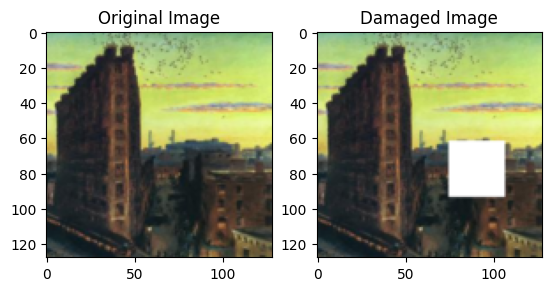

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

damaged_img, original_img = train_dataset[0]
mask = damaged_img[3, :, :]
damaged_img = damaged_img[:3, :, :]
damaged_img = damaged_img.permute(1, 2, 0)
original_img = original_img.permute(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Original Image")
ax1.imshow(original_img)
ax2.set_title("Damaged Image")
ax2.imshow(damaged_img)
plt.show()

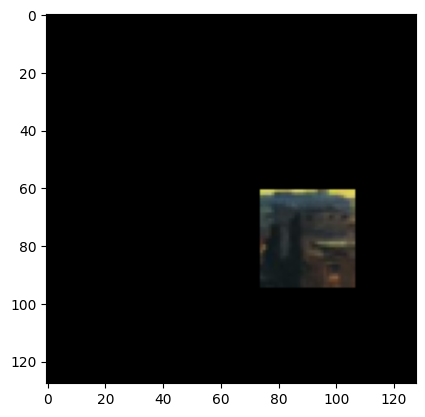

In [5]:
hole = original_img
hole[mask == 0] = 0
plt.imshow(hole)
plt.show()

In [6]:
from inpainting.InpaintingMOGAN import InpaintingMIGAN

model = InpaintingMIGAN()

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

trainer = Trainer(
        logger=comet_logger,
        max_epochs=100,
        accelerator="gpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(monitor="generator_loss", save_top_k=1, mode="min", filename="gan-inpainting-{epoch:02d}-{generator_loss:.2f}"),
            EarlyStopping('val_loss', patience=10)
        ]
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
torch.set_float32_matmul_precision('medium')

In [9]:
# from torchinfo import summary
# summary(model.generator, input_size=(4, 128, 128))
# summary(model.discriminator, input_size=(3, 128, 128))

In [10]:
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/anekil/image-inpainting/c9c8cbd4eeb546eebe114aa186a3a4cd

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type          | Params | Mode 
--------------------------------------------------------------
0 | generator           | UNetGenerator | 1.3 M  | train
1 | critique            | Critique      | 662 K  | train
2 | reconstruction_loss | L1Loss        | 0      | train
--------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.680     Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : watery_coyote_9957
COMET INFO:     url                   : https://www.comet.com/anekil/image-inpainting/c9c8cbd4eeb546eebe114aa186a3a4cd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     critique_loss_epoch [15]  : (0.147026926279068, 671.3043823242188)
COMET INFO:     critique_loss_step [94]   : (-0.19231493771076202, 2565.434326171875)
COMET INFO:     generator_loss_epoch [15] : (-4740.68701171875, 18.543655395507812)
COMET INFO:     generator_loss_step [94]  : (-6141.3056640625, 23.024272918701172)
COMET INFO:     loss [2827]               : (-6013.458984375, 100633.0078125)
CO

NameError: name 'exit' is not defined

In [ ]:
trainer.test(model, dataloaders=test_dataloader)